# Load libraries


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min, norm, geom, uniform, lognorm
from scipy.linalg import solve

In [2]:
# Set the root directory to be able to access other folders in the project

CURR_DIR = os.getcwd()  # current working directory
BASE_DIR = Path(CURR_DIR).parent  # parent directory
print(BASE_DIR)

/home/adrien/Documents/Github/MFA/02_stock_driven_and_surv_curves


# Import data


In [3]:
# Load input data, stock-driven model:
# and check your data

file_path = BASE_DIR / "data_input" / "MFA_II_tutorial_II.xlsx"
data = pd.read_excel(file_path, sheet_name="stock_driven")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     61 non-null     int64  
 1   stock    61 non-null     int64  
 2   inflow   0 non-null      float64
 3   outflow  0 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 2.0 KB


In [4]:
# set the index to year
data = data.set_index(["year"])

years = data.index
end_year = years[-1]
print(f"end_year = {end_year}")

data

end_year = 2050


,stock,inflow,outflow
year,,,
1990,20,NaN,NaN
1991,21,NaN,NaN
1992,30,NaN,NaN
1993,39,NaN,NaN
1994,45,NaN,NaN
...,...,...,...
2046,724,NaN,NaN
2047,737,NaN,NaN
2048,750,NaN,NaN


In [5]:
data_length = data.shape[0]
timesteps = np.arange(0, data_length)

# Create a survival curve

(if one wasn't supplied as input data)

--> see `week_2_tutorial_survival_curves.ipynb` notebook first


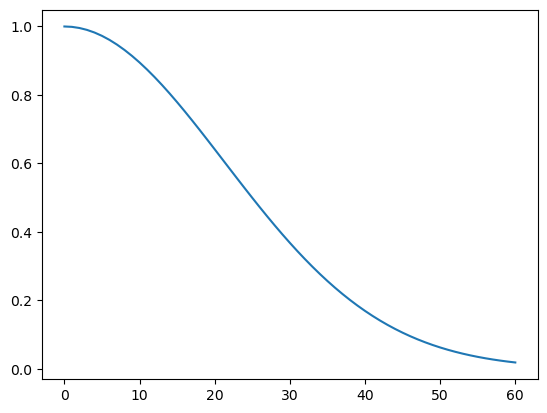

In [6]:
# Weibull distribution
survival_curve = weibull_min.sf(
    timesteps,
    c=2,  # controls the shape of the curve (skewness)
    loc=0,  # shifts the curve along the x-axis (starting point)
    scale=30,  # Stretches or compresses the curve along the x-axis (spread)
)

plt.plot(survival_curve)
plt.show()

# Create a survival curve matrix

--> see `week_2_tutorial_survival_curves.ipynb` notebook first


![filling_survival_curve_matrix](../../img/filling_survival_curve_matrix.png)


In [ ]:
# create survival curve matrix with placeholder zeros
survival_curve_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)

# and populate that matrix
for year in timesteps:
    # at each iteration, we take 1 year less of the survival curve
    last_idx = data_length - year
    values = survival_curve[0:last_idx]
    # and we assign the sliced values to the sliced matrix:
    # --> rows: from step to step_max
    # --> columns: only the current step
    survival_curve_matrix.loc[year:data_length, year] = values

survival_curve_matrix

# Stock driven model


In [ ]:
# This is our model input
stock = data["stock"]
stock

![stock_driven_equations](../../img/stock_driven_equations.png)

![filling_stock_driven_cohort_matrix](../../img/filling_stock_driven_cohort.png)


In [ ]:
# create inflow series and survival matrix with
# placeholder zeros, that we will populate
inflows = pd.Series(0, index=years, dtype=float)
cohort_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)

In [ ]:
# start with year = 0, then change it and see
# how the other values are updated in the following 2 cells
year = 0  # take any value in timesteps [0...60]
stock.iloc[year]

**Question:**

1. What does this value represent?


**ANSWER**


...


In [ ]:
# For the row, we only take the current year from the cohort matrix
# and for the column, we take all of them
cohort_matrix.loc[year, :]

**Question:**

2. What does this array represent? And if we sum it, what does it represent?


**ANSWER**


...


In [ ]:
survival_curve_matrix.loc[year, year]

**Question:**

3. What does this value represent? Why do we care about it?


**ANSWER**


...


In [ ]:
# Now we put it together to populate the cohort_matrix
for year in timesteps:
    # calculate the difference between current stock and the sum of all
    # what remains from previous inflows
    difference = stock.iloc[year] - cohort_matrix.loc[year, :].sum()
    inflows.iloc[year] = difference / survival_curve_matrix.loc[year, year]
    # the line below is the same as for flow driven models
    cohort_matrix.loc[:, year] = survival_curve_matrix.loc[:, year] * inflows.iloc[year]

cohort_matrix

In [ ]:
# set index and columns to years instead of timesteps
cohort_matrix.index = years
cohort_matrix.columns = years

# and visualize the cohort_matrix matrix with a heatmap
sns.heatmap(cohort_matrix, annot=False)

$$\text{NAS}(y) = \text{stock}(y) - \text{stock}(y-1)$$


In [ ]:
# calculate the net addition to stock
# nas =

# ! ANSWER

$$\text{outflow}(y) = \text{inflow}(y) - \text{NAS}(y)$$


In [ ]:
# calculate outflows and nas:
# nas =

# ! ANSWER

# Visualize the results


In [ ]:
data["stock"] = stock
data["outflow"] = outflows
data["nas"] = nas

data

In [ ]:
# Visualize on the same plot
data.plot()

In [ ]:
# Zooming in the flows and net addition to stock
data[["inflow", "outflow", "nas"]].plot()

In [ ]:
# Visualize the stock by cohort_matrixs
cohort_matrix.plot(kind="area", stacked=True, legend=False)

# Export output data to Excel


In [ ]:
# Save the data to an Excel file
# (you may need to create the folder if it doesn't exist)
file_path = BASE_DIR / "data_output" / "week_2_tutorial_myname.xlsx"
data.to_excel(file_path, sheet_name="stock_driven")

In [ ]:
# But we also want to save the cohort_matrix data in the same excel file
# without overwriting the file.
# To do that, we open an Excel file in append mode ('a')
# https://pandas.pydata.org/docs/reference/api/pandas.ExcelWriter.html

with pd.ExcelWriter(file_path, mode="a") as writer:
    cohort_matrix.to_excel(writer, sheet_name="cohort_matrix_stock_driven")

---


# Going further

--> We saw in `week_2_tutorial_survival_curves.ipynb` notebook that we could also define the `survival_curve` and the `survival_curve_matrix` as follows:


In [ ]:
# Instead of a numpy array, we store the survival curve
# as a pandas Series with the appropriate index (= years)
sf = pd.Series(survival_curve, index=years)

# create survival curve matrix with placeholder zeros (same as before)
survival_curve_matrix2 = pd.DataFrame(0, index=years, columns=years, dtype=float)

# populate the survival curve matrix with shifted curves, column by column using slices
# ! This time we use the years as index instead of the timesteps
for counter, year in enumerate(years):
    # at each iteration, we take 1 year less of the survival curve
    last_idx = end_year - counter
    values = sf.loc[:last_idx].values
    # and we assign the sliced values to the sliced matrix:
    # --> rows: from current year to the end year
    # --> columns: only the current year
    survival_curve_matrix2.loc[year:end_year, year] = values

Now let's utilize numpy and pandas capacities to **optimize** our stock driven model


There are different types of matrix multiplications:

- the **dot product** (using the `np.dot()` function or the `@` operator)?
- the **element-wise matrix multiplication** (`np.multiply()` function or `*` operator)

The **dot product** does the following:

$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
f_1 \\
f_2 \\
f_3
\end{bmatrix}
=
\begin{bmatrix}
a_{11} f_1 + a_{12} f_2  + a_{13} f_3  \\
a_{21} f_1 + a_{22} f_2  + a_{23} f_3  \\
a_{31} f_1 + a_{32} f_2  + a_{33} f_3  \\
\end{bmatrix}
$$

Now assuming that

- the matrix $\mathbf{A}$ represents the `survival_curve_matrix`
- and the vector $\mathbf{f}$ represents the `inflows`,

we get:

$$
\begin{bmatrix}
a_{1} & 0 & 0 \\
a_{2} & a_{1} & 0 \\
a_{3} & a_{2} & a_{1} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
f_1 \\
f_2 \\
f_3
\end{bmatrix}
=
\begin{bmatrix}
a_{1} f_1 \\
a_{2} f_1 + a_{1} f_2  \\
a_{3} f_1 + a_{2} f_2  + a_{1} f_3  \\
\end{bmatrix}
$$

You may recognize the `stock` vector $\mathbf{s}$ as the result

In other words, we have the following system of linear equations:

$$
\begin{align}
\mathbf{A} \cdot \mathbf{f} &= \mathbf{s} \\
\mathbf{f} &= \mathbf{A}^{-1} \cdot \mathbf{s}
\end{align}
$$

And `scipy.linalg.solve()` can help us solve it

$$\mathbf{f} = \text{solve}(\mathbf{A}, \mathbf{s})$$


In [ ]:
# the linear algebra library in scipy allows us to solve this
# but it returns a numpy array, so we convert it into a Pandas Series
inflows2 = solve(survival_curve_matrix2, stock)
inflows2 = pd.Series(inflows2, index=years)
inflows2

In [ ]:
# Check that they are indeed the same
# always use np.allclose() instead of == to compare floats
np.allclose(inflows2, inflows)

# More information and tips


- [Statistical functions in scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
- the `enumerate()` function on [W3school](https://www.w3schools.com/python/ref_func_enumerate.asp) or [Programiz](https://www.programiz.com/python-programming/methods/built-in/enumerate)
- [Pandas excel writer](https://pandas.pydata.org/docs/reference/api/pandas.ExcelWriter.html)
- Difference between `np.dot()`, `np.multiply()` and `np.matmul()` on [codeacademy](https://www.codecademy.com/article/numpy-matrix-multiplication-a-beginners-guide) or [digitalocean](https://www.digitalocean.com/community/tutorials/numpy-matrix-multiplication)
- [Scipy Solver](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html) from the [Linear Algebra library](https://docs.scipy.org/doc/scipy/reference/linalg.html)
